In [683]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split

In [684]:
X_true_test_df = pd.read_csv("test_processed.csv", index_col=0)
train_df = pd.read_csv("train_processed.csv", index_col=0)

Y_train_df = train_df["target"]
X_train_df = train_df.drop("target", axis=1)
# test_df = train_df.drop("accident_id", axis=1)
# train_df = train_df.drop("accident_id", axis=1)

In [685]:
X_true_test_df = X_true_test_df[:2000]
Y_train_df = Y_train_df[:2000]
X_train_df = X_train_df[:2000]

In [686]:
X_train = X_train_df.values
Y_train = Y_train_df.values
X_true_test = X_true_test_df.values

# Defines

In [687]:
def standarize(df):
    return (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))


def boruta_feature_selection(x, y):
    rfc = RandomForestClassifier(n_estimators=200,
                                 n_jobs=-1,
                                 class_weight='balanced',
                                 max_depth=7,
                                 random_state=0)
    boruta_selector = BorutaPy(rfc,
                               n_estimators='auto',
                               verbose=1,
                               random_state=0)
    boruta_selector.fit(x, y)
    features = np.where(boruta_selector.support_ +
                        boruta_selector.support_weak_ == True)[0]
    print(f"\rBoruta\nNumber of Selected Features: {features.shape[0]}")
    print("Selected Features: ")
    print(*features.tolist(), sep=", ")
    return features.tolist()


def calculate_r_2_for_feature(data, feature, regression_type):
    new_data = data.drop(feature, axis=1)

    X_train, \
    X_test,  \
    y_train, \
    y_test = train_test_split(
        new_data,data[feature],test_size=0.25
    )
    if regression_type == "KNR":
        regressor = KNeighborsRegressor()
    elif regression_type == "DTR":
        regressor = DecisionTreeRegressor()
    else:
        raise Exception("Wrong type of regression, use:\n",
                        "KNR for KNeighborsRegressor\n",
                        "DTR for DecisionTreeRegressor")
    regressor.fit(X_train, y_train)

    # score returns the coefficient of determination R^2 of the prediction.
    score = regressor.score(X_test, y_test)
    return score


def calculate_mean_r_2(data, feature, regression_type, iteration=10):
    scores = []
    for i in range(iteration):
        scores.append(calculate_r_2_for_feature(data, feature,
                                                regression_type))
    scores = np.array(scores)
    return scores.mean()


def r_2_score_denoisser(X_train, regression_type="KNR"):
    x_df = pd.DataFrame(X_train)
    avg_r2_feature_scores = []
    for column in tqdm(x_df.columns):
        score = calculate_mean_r_2(x_df.sample(n=30, random_state=1), column,
                                   regression_type)
        avg_r2_feature_scores.append(score)

    features = [i for i, r2 in enumerate(avg_r2_feature_scores) if r2 > 0]
    print("R\u00b2 Score Denoisser\nRegressor:", end=" ")
    if regression_type == "KNR":
        print("KNeighborsRegressor")
    elif regression_type == "DTR":
        print("DecisionTreeRegressor")
    print(f"Number of Selected Features: {len(features)}")
    print("Selected Feaures: ")
    print(*features, sep=", ")
    return features

In [688]:
features_DTR = r_2_score_denoisser(X_train, regression_type="DTR")


R² Score Denoisser
Regressor: DecisionTreeRegressor
Number of Selected Features: 79
Selected Feaures: 
7, 8, 9, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 92, 93, 95, 98, 99, 101, 102


In [689]:
features_KNR = r_2_score_denoisser(X_train, regression_type="KNR")


R² Score Denoisser
Regressor: KNeighborsRegressor
Number of Selected Features: 70
Selected Feaures: 
8, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 51, 53, 54, 56, 57, 58, 59, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 86, 90, 92, 93, 101, 102


In [690]:
features_boruta = boruta_feature_selection(X_train, Y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [666]:
features = [
    3, 7, 8, 11, 12, 13, 15, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
    31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 51, 53, 54,
    55, 56, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
    76, 77, 78, 80, 81, 82, 83, 85, 93, 100, 101, 102
]

In [667]:
col_names = X_train_df.iloc[:, features].columns
X_train_sel = X_train[:, features]
x_train, x_test, y_train, y_test = train_test_split(X_train_sel,
                                                    Y_train,
                                                    test_size=0.25)

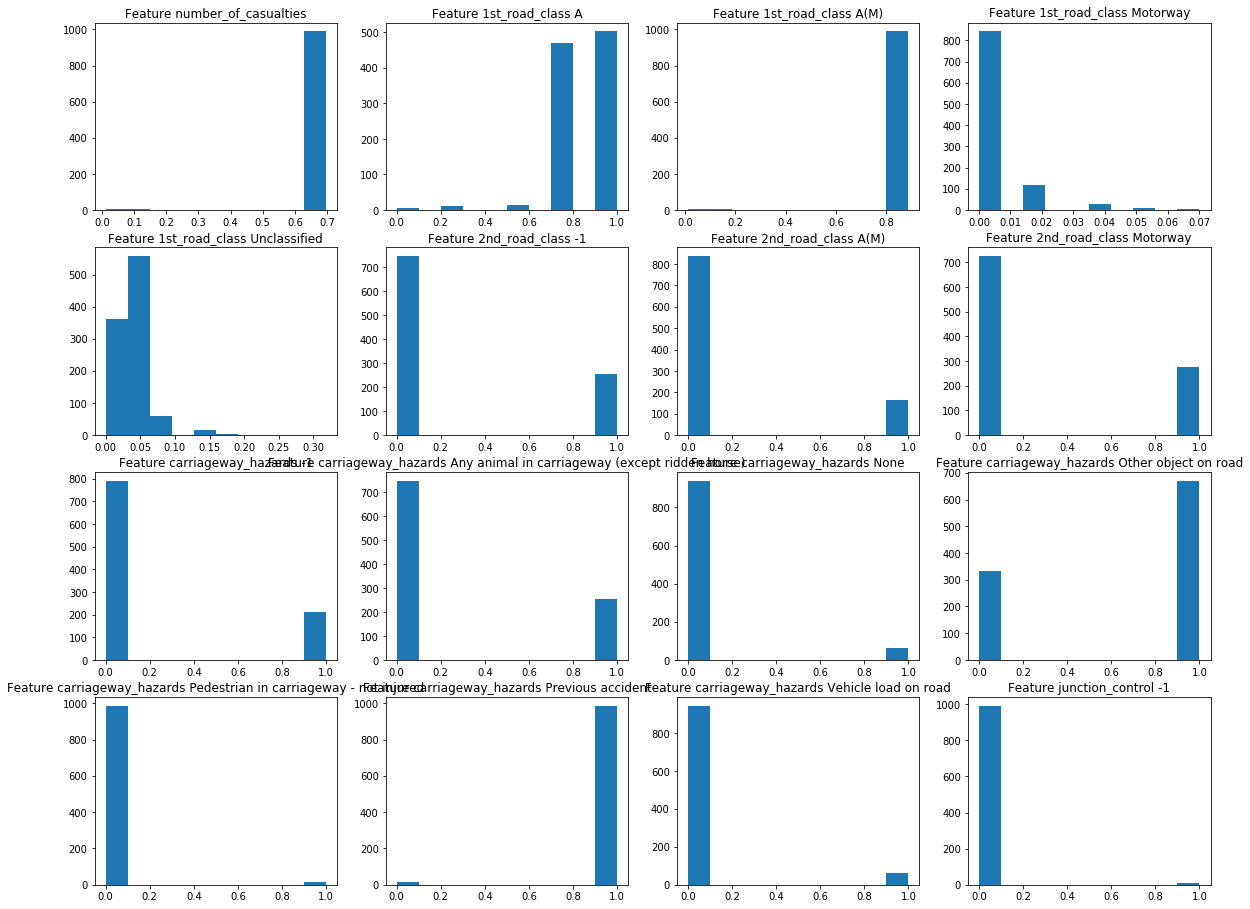

In [551]:
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    fig.add_subplot(5, 4, i + 1)
    plt.hist(x_train_sel[:, i])
    plt.title(f"Feature {col_names[i]}")

In [552]:
from sklearn.metrics import f1_score

# Logistic Regression

In [553]:
x_train.mean()

0.13342608695652172

In [554]:
logregPipe = Pipeline([('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(random_state=123))])
_ = logregPipe.fit(x_train, y_train)

In [555]:
print('accuracy on the tain set: ', logregPipe.score(x_train, y_train))
print('accuracy on the test set: ', logregPipe.score(x_test, y_test))
print(f1_score(y_train, logregPipe.predict(x_train)))
print(f1_score(y_test, logregPipe.predict(x_test)))

accuracy on the tain set:  0.8882666666666666
accuracy on the test set:  0.88
0.0
0.0


           selected parameter
logreg__C               0.001


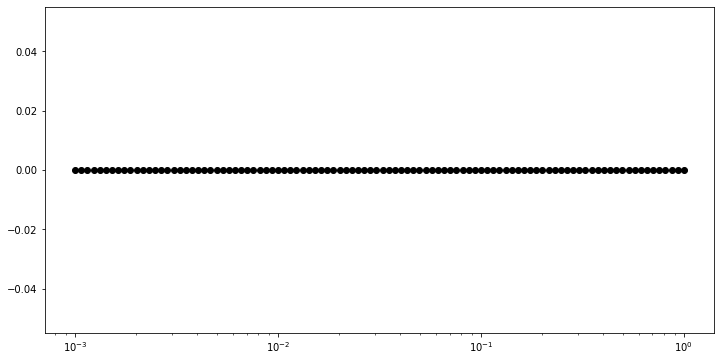

In [556]:
param_space = np.logspace(-3, 0, 100)
logregParam = {'logreg__C': param_space}
logregGS = GridSearchCV(estimator=logregPipe,
                        param_grid=logregParam,
                        cv=5,
                        scoring='f1')
logregGS.fit(x_train, y_train)
print(
    pd.DataFrame.from_dict(logregGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = logregGS.cv_results_["mean_test_score"]
std_test_score = logregGS.cv_results_["std_test_score"]
plt.figure(figsize=(12, 6))
plt.errorbar(param_space, mean_test_score, std_test_score, fmt='ok', lw=3)
plt.xscale('log')
logregGS.estimator.steps[1][1].C = logregGS.best_params_["logreg__C"]

In [557]:
from sklearn.metrics import roc_curve, auc


def roc_curve_plot(clf, x_train, y_train, x_test, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_score = clf.fit(x_train, y_train).decision_function(x_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Compute micro-average ROC curve and ROC area
    plt.figure()
    lw = 2
    plt.plot(fpr,
             tpr,
             color='darkorange',
             lw=lw,
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

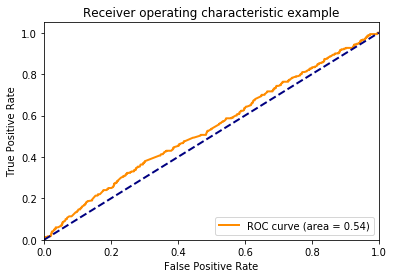

In [558]:
roc_curve_plot(logregGS, x_train, y_train, x_test, y_test)

In [559]:
print("accuracy on the test set: ",
      accuracy_score(y_test, logregGS.predict(x_test)))
print("accuracy on the train set: ",
      accuracy_score(y_train, logregGS.predict(x_train)))
print(f1_score(y_train, logregGS.predict(x_train)))
print(f1_score(y_test, logregGS.predict(x_test)))

accuracy on the test set:  0.88
accuracy on the train set:  0.8882666666666666
0.0
0.0


In [560]:
logregGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, logregGS.predict(x_test)), columns=['Predicted 0', 'Predicted 1'],\
                                index=['Actual 0', 'Actual 1'])
logregGS_confMatrix

,Predicted 0,Predicted 1
Actual 0,2200,0
Actual 1,300,0


# KNeighborsClassifier

In [561]:
knnPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_jobs=-1)),
])
knnParam = {
    'knn__n_neighbors': range(1, 12),
    'knn__weights': ['uniform', 'distance'],
}
_ = knnPipe.fit(x_train, y_train)

In [562]:
print('accuracy on the train set: ', knnPipe.score(x_train, y_train))
print('accuracy on the test set: ', knnPipe.score(x_test, y_test))
print(f1_score(y_train, knnPipe.predict(x_train)))
print(f1_score(y_test, knnPipe.predict(x_test)))

accuracy on the train set:  0.8841333333333333
accuracy on the test set:  0.872
0.06659505907626208
0.01840490797546012


                 selected parameter
knn__n_neighbors                  1
knn__weights                uniform


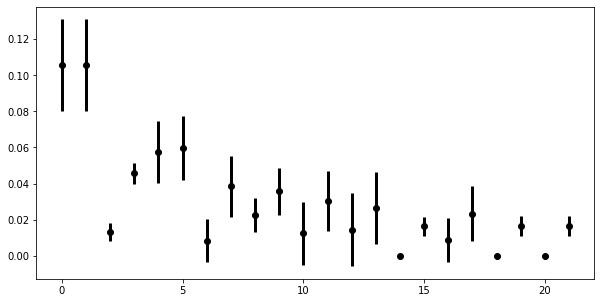

In [563]:
knnGS = GridSearchCV(knnPipe, param_grid=knnParam, n_jobs=-1, scoring='f1')
_ = knnGS.fit(x_train, y_train)
print(
    pd.DataFrame.from_dict(knnGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = knnGS.cv_results_["mean_test_score"]
std_test_score = knnGS.cv_results_["std_test_score"]
plt.figure(figsize=(10, 5))
_ = plt.errorbar(np.arange(mean_test_score.shape[0]),
                 mean_test_score,
                 std_test_score,
                 fmt='ok',
                 lw=3)

In [564]:
print("accuracy on the train set: ", knnGS.score(x_train, y_train))
print("accuracy on the test set:", knnGS.score(x_test, y_test))
print(f1_score(y_train, knnGS.predict(x_train)))
print(f1_score(y_test, knnGS.predict(x_test)))

accuracy on the train set:  0.41504539559014264
accuracy on the test set: 0.14471243042671614
0.41504539559014264
0.14471243042671614


In [565]:
knnGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, knnGS.predict(x_test)), \
                                columns=['Predicted 0', 'Predicted 1'], \
                                index=['Actual 0', 'Actual 1'])
knnGS_confMatrix

,Predicted -1,Predicted 1
Actual -1,2000,200
Actual 1,261,39


# DecisionTree Classifier

In [670]:
dectreePipe = Pipeline([('scaler', StandardScaler()),
                        ('dectree', DecisionTreeClassifier(random_state=123))])
dectreeParam = {
    'dectree__criterion': ['entropy'],
    'dectree__class_weight': ['balanced'],
    'dectree__max_depth': [5],
}
# _ = dectreePipe.fit(x_train, y_train)

In [624]:
# print('accuracy on the train set: ', dectreePipe.score(x_train, y_train))
# print('accuracy on the test set: ', dectreePipe.score(x_test, y_test))
# print(f1_score(y_train, dectreePipe.predict(x_train)))
# print(f1_score(y_test, dectreePipe.predict(x_test)))

                      selected parameter
dectree__class_weight           balanced
dectree__criterion               entropy
dectree__max_depth                     5


<ErrorbarContainer object of 3 artists>

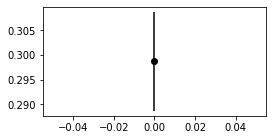

In [671]:
dectreeGS = GridSearchCV(dectreePipe,
                         param_grid=dectreeParam,
                         cv=5,
                         scoring='f1')
_ = dectreeGS.fit(x_train, y_train)
print(
    pd.DataFrame.from_dict(dectreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))
mean_test_score = dectreeGS.cv_results_["mean_test_score"]
std_test_score = dectreeGS.cv_results_["std_test_score"]
plt.figure(figsize=(4, 2))
plt.errorbar(np.arange(mean_test_score.shape[0]),
             mean_test_score,
             std_test_score,
             fmt='ok')

In [672]:
print('f1_score on the train set: ', dectreeGS.score(x_train, y_train))
print('f1_score on the test set: ', dectreeGS.score(x_test, y_test))

f1_score on the train set:  0.29916885849552866
f1_score on the test set:  0.29839260224663317


In [673]:
pd.DataFrame(confusion_matrix(y_test, dectreeGS.predict(x_test)),
             columns=['Predicted -1', 'Predicted 1'],
             index=['Actual 0', 'Actual 1'])

,Predicted -1,Predicted 1
Actual 0,20691,7717
Actual 1,3588,2404


# Random Forest

In [677]:
class_weight = dict({0.0: 9, 1.0: 1})
randtreePipe = Pipeline([('scaler', StandardScaler()),
                         ('randtree',
                          RandomForestClassifier(random_state=123,
                                                 n_estimators=100,
                                                 bootstrap=True,
                                                 class_weight=class_weight))])

randtreeParam = {
    'randtree__max_depth': [15],
}

# _ = randtreePipe.fit(x_train, y_train)

In [678]:
# print('accuracy on the train set: ', randtreePipe.score(x_train, y_train))
# print('accuracy on the test set: ', randtreePipe.score(x_test, y_test))
# print(f1_score(y_train, randtreePipe.predict(x_train)))
# print(f1_score(y_test, randtreePipe.predict(x_test)))

                     selected parameter
randtree__max_depth                  15


<ErrorbarContainer object of 3 artists>

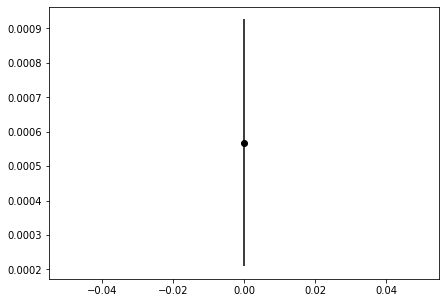

In [679]:
randtreeGS = GridSearchCV(randtreePipe,
                          param_grid=randtreeParam,
                          cv=5,
                          scoring='f1')
randtreeGS.fit(x_train, y_train)
mean_test_score = randtreeGS.cv_results_["mean_test_score"]

std_test_score = randtreeGS.cv_results_["std_test_score"]

print(
    pd.DataFrame.from_dict(randtreeGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))

pd.DataFrame(randtreeGS.cv_results_).sort_values(by='rank_test_score')[:5][[
    'rank_test_score', 'param_randtree__max_depth', 'mean_test_score',
    'std_test_score'
]].T

plt.figure(figsize=(7, 5))
plt.errorbar(np.arange(mean_test_score.shape[0]),
             mean_test_score,
             std_test_score,
             fmt='ok')

In [680]:
print("f1_score on the train set", randtreeGS.score(x_train, y_train))
print("f1_score on the test set", randtreeGS.score(x_test, y_test))

f1_score on the train set 0.006114822783376741
f1_score on the test set 0.0


In [681]:
randtreeGS_confMatrix = pd.DataFrame(confusion_matrix(y_test, randtreeGS.predict(x_test)), columns=['Predicted 0', \
                                                                                               'Predicted 1'],\
                                   index=['Actual 0', 'Actual 1'])
randtreeGS_confMatrix

,Predicted 0,Predicted 1
Actual 0,28407,1
Actual 1,5992,0


# XGBoost

In [628]:
dtc = DecisionTreeClassifier(random_state=123, criterion = 'entropy', class_weight = 'balanced', max_depth=4, scoring='f1')
dtc.fit(x_train, y_train)
dtc.score(x_train, y_train), dtc.score(x_test, y_test), dtc.get_params()["scoring"]

TypeError: __init__() got an unexpected keyword argument 'scoring'

In [668]:
y_train.shape

(103199,)

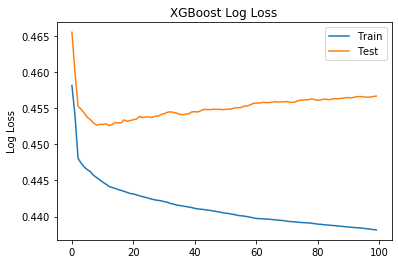

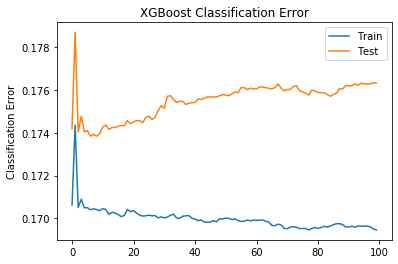

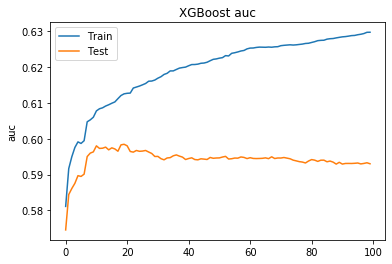

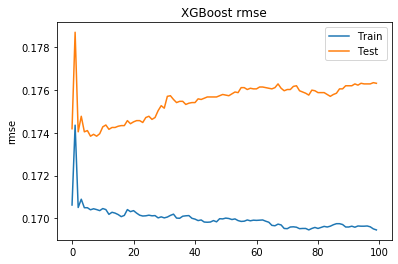

In [669]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=1.5)
eval_set = [(x_train, y_train), (x_test, y_test)]
xgb.fit(x_train, y_train, eval_metric=["error", "logloss", "auc", "rmse"], eval_set=eval_set, verbose=False)
pd.DataFrame(confusion_matrix(y_test, xgb.predict(x_test)),
             columns=['Predicted 0', 'Predicted 1'],
             index=['Actual 0', 'Actual 1'])

results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.title('XGBoost auc')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()

In [675]:
confMatrix = pd.DataFrame(confusion_matrix(y_test, xgb.predict(x_test)), columns=['Predicted 0', \
                                                                                               'Predicted 1'],\
                                   index=['Actual 0', 'Actual 1'])
confMatrix

,Predicted 0,Predicted 1
Actual 0,28247,161
Actual 1,5904,88


In [602]:
# Cross validation scores
f1_scores = cross_val_score(xgb, x_train, y_train, cv=5, scoring='f1')
print("F1-score = ",f1_scores," Mean F1 score = ",np.mean(f1_scores))
 
# Training the models
xgb.fit(x_train, y_train)
 
# Scoring on test set
test_data,score_xgb = score_on_test_set(xgb,"test.csv","submission_xgb.csv")

F1-score =  [0. 0. 0. 0. 0.]  Mean F1 score =  0.0


NameError: name 'score_on_test_set' is not defined

In [605]:
def xg_f1(t,y):
#     t = t.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y] # binaryzing your output
    return 'f1',f1_score(t,y_bin)


xg_f1(y_train, xgb.predict(x_train))

('f1', 0.0)

In [593]:
# xgbGS = GridSearchCV(xgbPipe,
#                           param_grid=xgbParam,
#                           cv=5,
#                           scoring='f1')
xgb.fit(x_train, y_train)
# mean_test_score = xgb.cv_results_["mean_test_score"]

# std_test_score = xgb.cv_results_["std_test_score"]

print(
    pd.DataFrame.from_dict(xgbGS.best_params_,
                           orient='index',
                           columns=["selected parameter"]))

# pd.DataFrame(xgbGS.cv_results_).sort_values(by='rank_test_score')[:5][[
#     'rank_test_score', 'param_randtree__max_depth', 'mean_test_score',
#     'std_test_score'
# ]].T

plt.figure(figsize=(7, 5))
plt.errorbar(np.arange(mean_test_score.shape[0]),
             mean_test_score,
             std_test_score,
             fmt='ok')

AttributeError: 'XGBClassifier' object has no attribute 'cv_results_'

# Porównanie Dokładności Modeli

In [266]:
print("Logistic Regression")
print("accuracy on the train set: ", logregGS.score(x_train, y_train))
print("accuracy on the test set: ", logregGS.score(x_test, y_test))
print(f1_score(y_train, logregGS.predict(x_train)))
print(f1_score(y_test, logregGS.predict(x_test)))

print("\nK-Neighbors Classifier")
print("accuracy on the train set: ", knnGS.score(x_train, y_train))
print("accuracy on the test set:", knnGS.score(x_test, y_test))
print(f1_score(y_train, knnGS.predict(x_train)))
print(f1_score(y_test, knnGS.predict(x_test)))

print("\nDecision Tree Classifier")
print('accuracy on the train set: ', dectreeGS.score(x_train, y_train))
print('accuracy on the test set: ', dectreeGS.score(x_test, y_test))
print(f1_score(y_train, dectreeGS.predict(x_train)))
print(f1_score(y_test, dectreeGS.predict(x_test)))

print("\nRandomForestClassifier")
print("accuracy on the train set", randtreeGS.score(x_train, y_train))
print("accuracy on the test set", randtreeGS.score(x_test, y_test))
print(f1_score(y_train, randtreeGS.predict(x_train)))
print(f1_score(y_test, randtreeGS.predict(x_test)))

Logistic Regression
accuracy on the train set:  0.0
accuracy on the test set:  0.0
0.0
0.0

K-Neighbors Classifier
accuracy on the train set:  1.0
accuracy on the test set: 0.1764705882352941
1.0
0.1764705882352941

Decision Tree Classifier
accuracy on the train set:  1.0
accuracy on the test set:  0.08571428571428572
1.0
0.08571428571428572

RandomForestClassifier
accuracy on the train set 1.0
accuracy on the test set 0.18181818181818182
1.0
0.18181818181818182


In [268]:
Y_train.shape

(1000,)

In [269]:
print("Logistic Regression")
for features_name, features in {
        'features_KNR': features_KNR,
        'features_DTR': features_DTR,
        'features_boruta': features_boruta,
}.items():
    print("\t", features_name, len(features))
    x_sel = X_train_df.iloc[:, features]
    x_val_sel = X_train_df.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,
                                                        Y_train,
                                                        test_size=0.25)

    #     x_sel = x_df.iloc[:, features]
    #     x_val_sel = x_df_val.iloc[:, features]
    #     x_train, x_test, y_train, y_test = train_test_split(x_sel,y_df,test_size=0.25)

    param_space = np.logspace(-3, 0, 100)
    logregParam = {'logreg__C': param_space}
    logregPipe = Pipeline([('scaler', StandardScaler()),
                           ('logreg', LogisticRegression(random_state=123))])
    logregGS = GridSearchCV(estimator=logregPipe,
                            param_grid=logregParam,
                            cv=5,
                            scoring='f1')
    logregGS.fit(x_train, y_train)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)

    cv_train = cross_val_score(logregGS,
                               x_train,
                               y_train,
                               cv=skf,
                               scoring="f1")
    cv_test = cross_val_score(logregGS, x_test, y_test, cv=skf, scoring="f1")

    print("\t\tCV f1 on the train set: ", cv_train.mean().round(3) * 100, "%")
    print("\t\tCV f1 on the test set:", cv_test.mean().round(3) * 100, "%")

#     print("\t\taccuracy on the train set: ", logregGS.score(x_train, y_train).round(3))
#     print("\t\taccuracy on the test set:", logregGS.score(x_test, y_test).round(3))

Logistic Regression
	 features_KNR 75
		CV f1 on the train set:  0.0 %
		CV f1 on the test set: 3.5999999999999996 %
	 features_DTR 75
		CV f1 on the train set:  0.0 %
		CV f1 on the test set: 12.0 %
	 features_boruta 16
		CV f1 on the train set:  0.0 %
		CV f1 on the test set: 4.3999999999999995 %


In [270]:
print("\nK-Neighbors Classifier")
for features_name, features in {
        'features_KNR': features_KNR,
        'features_DTR': features_DTR,
        'features_boruta': features_boruta,
}.items():
    print("\t", features_name, len(features))
    x_sel = X_train_df.iloc[:, features]
    x_val_sel = X_train_df.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,
                                                        Y_train,
                                                        test_size=0.25)
    knnPipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_jobs=-1)),
    ])
    knnParam = {
        'knn__n_neighbors': [1, 3, 5, 7, 8, 9, 10, 11],
        'knn__weights': ['uniform', 'distance'],
    }
    knnGS = GridSearchCV(knnPipe, param_grid=knnParam, n_jobs=-1, scoring="f1")
    _ = knnGS.fit(x_train, y_train)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)

    cv_train = cross_val_score(knnGS, x_train, y_train, cv=skf, scoring="f1")
    cv_test = cross_val_score(knnGS, x_test, y_test, cv=skf, scoring="f1")

    print("\t\tCV f1 on the train set: ", (cv_train.mean() * 100).round(3),
          "%")
    print("\t\tCV f1 on the test set:", (cv_test.mean() * 100).round(3), "%")

#     print("\t\taccuracy on the train set: ", knnGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", knnGS.score(x_test, y_test))


K-Neighbors Classifier
	 features_KNR 75
		CV f1 on the train set:  13.813 %
		CV f1 on the test set: 12.564 %
	 features_DTR 75
		CV f1 on the train set:  14.452 %
		CV f1 on the test set: 10.632 %
	 features_boruta 16
		CV f1 on the train set:  15.826 %
		CV f1 on the test set: 11.21 %


In [693]:
print("\nDecision Tree Clasifier")
for features_name, features in {
        'all': range(103),
        'features_KNR': features_KNR,
        'features_DTR': features_DTR,
#         'features_boruta': features_boruta,
}.items():
    print("\t", features_name, len(features))
    x_sel = X_train_df.iloc[:, features]
    x_val_sel = X_train_df.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,
                                                        Y_train,
                                                        test_size=0.25)

    dectreePipe = Pipeline([('scaler', StandardScaler()),
                            ('dectree',
                             DecisionTreeClassifier(random_state=123, class_weight='balanced', criterion='entropy'))])
    dectreeParam = {
        'dectree__max_depth': range(1,20),
    }
    dectreeGS = GridSearchCV(dectreePipe,
                             param_grid=dectreeParam,
                             cv=5,
                             scoring="f1")
    _ = dectreeGS.fit(x_train, y_train)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)

    cv_train = cross_val_score(dectreeGS,
                               x_train,
                               y_train,
                               cv=skf,
                               scoring="f1")
    cv_test = cross_val_score(dectreeGS, x_test, y_test, cv=skf, scoring="f1")

    print("\t\tCV f1 on the train set: ", (cv_train.mean() * 100).round(3),
          "%")
    print("\t\tCV f1 on the test set:", (cv_test.mean() * 100).round(3), "%")

#     print("\t\taccuracy on the train set: ", dectreeGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", dectreeGS.score(x_test, y_test))


Decision Tree Clasifier
	 all 103
		CV f1 on the train set:  26.853 %
		CV f1 on the test set: 27.408 %
	 features_KNR 70
		CV f1 on the train set:  19.269 %
		CV f1 on the test set: 25.846 %
	 features_DTR 79
		CV f1 on the train set:  21.68 %
		CV f1 on the test set: 22.732 %


In [272]:
print("\nRandom Forest Classifier")
for features_name, features in {
        'features_KNR': features_KNR,
        'features_DTR': features_DTR,
        'features_boruta': features_boruta,
}.items():
    print("\t", features_name, len(features))
    x_sel = X_train_df.iloc[:, features]
    x_val_sel = X_train_df.iloc[:, features]
    x_train, x_test, y_train, y_test = train_test_split(x_sel,
                                                        Y_train,
                                                        test_size=0.25)

    randtreePipe = Pipeline([('scaler', StandardScaler()),
                             ('randtree',
                              RandomForestClassifier(random_state=123,
                                                     n_estimators=100,
                                                     bootstrap=True))])
    max_depth_param = range(5, 25)
    randtreeParam = {'randtree__max_depth': max_depth_param}
    randtreeGS = GridSearchCV(randtreePipe,
                              param_grid=randtreeParam,
                              cv=5,
                              scoring="f1")
    randtreeGS.fit(x_train, y_train)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(x_train, y_train)

    cv_train = cross_val_score(randtreeGS,
                               x_train,
                               y_train,
                               cv=skf,
                               scoring="f1")
    cv_test = cross_val_score(randtreeGS, x_test, y_test, cv=skf, scoring="f1")

    print("\t\tCV f1 on the train set: ", (cv_train.mean() * 100).round(3),
          "%")
    print("\t\tCV f1 on the test set:", (cv_test.mean() * 100).round(3), "%")

#     print("\t\taccuracy on the train set: ", randtreeGS.score(x_train, y_train))
#     print("\t\taccuracy on the test set:", randtreeGS.score(x_test, y_test))


Random Forest Classifier
	 features_KNR 75
		CV f1 on the train set:  2.581 %
		CV f1 on the test set: 0.0 %
	 features_DTR 75
		CV f1 on the train set:  2.861 %
		CV f1 on the test set: 13.795 %
	 features_boruta 16
		CV f1 on the train set:  1.905 %
		CV f1 on the test set: 0.0 %


In [ ]:
# save_data = knnGS.predict_proba(x_val_sel)[:, 1]
# np.savetxt("foo.csv", save_data, delimiter="", fmt='%f', header="\r\"MATDOR\"")